# Project 3

In [1]:
import requests
import datetime as dt
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

#### Webscraping

Source:

Anshul's code. Introduced the while loop to pull more than 500 posts. 

In [2]:
def pull_subreddit_posts(subreddit, size):
    api_url = 'https://api.pushshift.io/reddit/search/submission'
    list_posts = []
    oldest_post = None
    while len(list_posts) < size:
        params = {'subreddit' : subreddit , 
                  'size' : size, 
                  'before' : oldest_post
                 }
        res = requests.get(api_url, params)
        data = res.json()
        posts = data['data']
        if len(posts) == 0:
            oldest_post = None
            list_posts.extend(posts)      
        else:
            time.sleep(3) #Learned this in class, we want to limit our queries to once every 3 seconds.
            oldest_post = dt.datetime.fromtimestamp(posts[-1]["created_utc"])
            list_posts.extend(posts)
    df = pd.DataFrame(posts)
    df.to_csv(subreddit + ".csv")
    return df.head()

In [3]:
pull_subreddit_posts('Bourbon', 1_000)

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,media,media_embed,secure_media,secure_media_embed,crosspost_parent,crosspost_parent_list,author_cakeday,author_flair_template_id,edited,distinguished
0,[],False,PM-me-your-kappas,None,[],None,text,t2_pga7a24,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,dlunde,None,[],None,text,t2_5fojf8x7,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,lawhmdthrowaway,None,[],None,text,t2_3m2d072d,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,mtlrat,None,[],None,text,t2_13ehhc,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,SailorBaylor,None,[],None,text,t2_5bjh49wx,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
pull_subreddit_posts('Scotch', 1_000)

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,media_embed,secure_media,secure_media_embed,link_flair_css_class,link_flair_template_id,link_flair_text,author_cakeday,crosspost_parent,crosspost_parent_list,poll_data
0,[],False,kellz0812,None,[],None,text,t2_5k3ta0rm,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,TheDude_never_abides,None,[],None,text,t2_14zw1n,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,CaptainKangarooster,None,[],None,text,t2_95qewa3,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,ChickenPotPi,None,[],None,text,t2_3sl5o,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],True,[deleted],None,NaN,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
Bourbon_df = pd.read_csv('Bourbon.csv')

In [6]:
Scotch_df = pd.read_csv('Scotch.csv')

#### Combining Dataframes

In [7]:
Combined_df = pd.concat([Bourbon_df, Scotch_df], ignore_index=True)

In [8]:
Combined_df = Combined_df[['subreddit', 'selftext', 'title']]

In [9]:
# Checking
Combined_df.head()

,subreddit,selftext,title
0,bourbon,NaN,Knob Creek Single Barrel - New Jersey Bourbon ...
1,bourbon,NaN,Found in the wild. Three on the shelf. Left tw...
2,bourbon,NaN,Is EH Taylor Small Batch worth $55?
3,bourbon,NaN,After loading flooring to install in June sinc...
4,bourbon,NaN,Anyone had this before? Picked it up for a fri...


#### EDA

In [10]:
# Check for nulls. NaN's in selftext indicate an image or video post with no accompanying text. 
Combined_df.isnull().sum()

subreddit       0
selftext     1339
title           0
dtype: int64

In [11]:
# Even number of nulls in either column
Combined_df['selftext'].isnull().groupby(Combined_df['subreddit']).sum().to_dict()

{'Scotch': 683.0, 'bourbon': 656.0}

In [12]:
# Fill all nulls with str "Blank"
Combined_df.fillna(value='Blank', inplace=True)

In [13]:
# Check for nulls
Combined_df.isnull().sum()

subreddit    0
selftext     0
title        0
dtype: int64

In [14]:
# Check Dtypes
Combined_df.dtypes

subreddit    object
selftext     object
title        object
dtype: object

In [15]:
# Drop duplicates (there were none)
Combined_df['title'] = Combined_df['title'].drop_duplicates(keep='last')

#### Lemmatize

In [16]:
# Instantiate
lemmatizer = WordNetLemmatizer()

Source:

Clint for the clean version of lemmatization. 

In [17]:
# Function to split words in dataframe series and lemmatize
def lemmatize_words(text):
    lemms = text.split()
    lemms_words = ''
    for lemms in lemms:
        lemms_words += (lemmatizer.lemmatize(lemms) + ' ')
    return lemms_words

In [18]:
# Had some floats in the title cells. Converted all to strings. 
Combined_df['title'] = Combined_df['title'].astype(str)

In [19]:
# Apply function to series/dataframe.
Combined_df['title'] = Combined_df['title'].apply(lemmatize_words)
Combined_df['title']

0       Knob Creek Single Barrel - New Jersey Bourbon ...
1       Found in the wild. Three on the shelf. Left tw...
2                    Is EH Taylor Small Batch worth $55? 
3       After loading flooring to install in June sinc...
4       Anyone had this before? Picked it up for a fri...
                              ...                        
1995                    Review: Octomore 10.2 "διάλογος" 
1996    Lagavulin ha always been the favorite, but the...
1997            Scotch ha a weird Robitussen after taste 
1998    Lagavulin 8 year: a youngster with much to offer 
1999                                 A nice evening dram 
Name: title, Length: 2000, dtype: object

#### Stopwords

In [20]:
# Save current stopwords as variable
words = stopwords.words('english')

In [21]:
# Identify new stopwords via iteration
extra_stopwords = 'day', 'pick', 'today', 'wa', 'know', 'just', 'got'

In [22]:
# Add new stopwords into original list
words.extend(extra_stopwords)

#### Model

In [23]:
# Define X and y
X = Combined_df['title']
y = Combined_df['subreddit']

In [24]:
# Train test split with stratify
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=42)

#### Baseline

In [25]:
# Baseline
y_test.value_counts(normalize=True)

bourbon    0.5
Scotch     0.5
Name: subreddit, dtype: float64

#### CountVectorizer

In [26]:
# Pipe parameters
pipe_params= {
    'cvec__max_features': [100, 500, 1_000, 2_000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)], 
    'cvec__max_df' : [0.5, 0.75, 0.9],
    'cvec__min_df' : [5, 50, 100, 500],
    'cvec__stop_words' : ['english', None, words]}

In [27]:
# Pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr' , LogisticRegression())
])

In [28]:
# Gridsearch
gs = GridSearchCV(pipe, 
                  pipe_params,
                  cv = 5) 

In [29]:
# Fit
gs.fit(X_train, y_train)

C:\Users\Jason\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "C:\Users\Jason\anaconda3\lib\site-packages\joblib\memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\Jason\anaconda

C:\Users\Jason\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "C:\Users\Jason\anaconda3\lib\site-packages\joblib\memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\Jason\anaconda

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.5, 0.75, 0.9],
                         'cvec__max_features': [100, 500, 1000, 2000],
                         'cvec__min_df': [5, 50, 100, 500],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': ['english', None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', 

In [30]:
# Best Parameters
gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 500,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

In [31]:
# Best Estimator 
gs_model = gs.best_estimator_

In [32]:
# Score Train
gs_model.score(X_train, y_train)

0.9033333333333333

In [33]:
# Score Test
gs_model.score(X_test, y_test)

0.825

#### TF-IDF

In [34]:
# Setup pipeline for TF-IDF
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr' , LogisticRegression())
])

In [35]:
# Pipe parameters
pipe_params_tvec = {
    'tvec__max_features': [100, 500, 1_000, 2_000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)], 
    'tvec__max_df' : [0.5, 0.75, 0.9],
    'tvec__min_df' : [5, 50, 100, 500],
    'tvec__stop_words' : ['english', None, words]}

In [36]:
# Gridsearch
gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                       pipe_params_tvec, # what parameters values are we searching?
                       cv = 5) # 5-fold cross-validation.

In [37]:
# Fit Model
gs_tvec.fit(X_train, y_train)

C:\Users\Jason\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "C:\Users\Jason\anaconda3\lib\site-packages\joblib\memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\Jason\anaconda

C:\Users\Jason\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "C:\Users\Jason\anaconda3\lib\site-packages\joblib\memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\Jason\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\Jason\anaconda

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'tvec__max_df': [0.5, 0.75, 0.9],
                         'tvec__max_features': [100, 500, 1000, 2000],
                         'tvec__min_df': [5, 50, 100, 500],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': ['english', None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', 

In [38]:
# Best Paramaters 
gs_tvec.best_params_

{'tvec__max_df': 0.5,
 'tvec__max_features': 500,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [39]:
# Best Estimator
gs_model_tvec = gs_tvec.best_estimator_

In [40]:
# Score Train
gs_model_tvec.score(X_train, y_train)

0.9

In [41]:
# Score Tests
gs_model_tvec.score(X_test, y_test)

0.82

#### Naive Bayes - Multinomial

In [42]:
# Instantiate
cvec = CountVectorizer()

In [43]:
# Transform
train_features = cvec.fit_transform(X_train)
test_features = cvec.transform(X_test)

In [44]:
# Turn into arrays
train_features = train_features.toarray()
test_features = test_features.toarray()

In [45]:
# Instantiate
mnb = MultinomialNB()

In [46]:
# Fit
mnb.fit(train_features, y_train)

MultinomialNB()

In [47]:
# Train Score
mnb.score(train_features, y_train)

0.9511111111111111

In [48]:
# Test Score
mnb.score(test_features, y_test)

0.87

#### Confusion Matrix (Gridsearch)

In [49]:
# Generate predictions.
preds = gs_model.predict(X_test)

In [50]:
# Define confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f' true neg {tn}, false pos {fp}, false neg {fn}, true pos {tp}')

 true neg 80, false pos 20, false neg 15, true pos 85


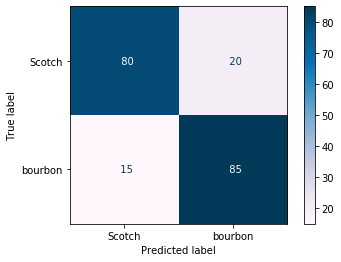

In [51]:
# Plot confusion matrix
plot_confusion_matrix(gs_model, 
                      X_test, 
                      y_test, 
                      cmap="PuBu", 
                      values_format='4g');

In [52]:
sensitivity = tp / (tp + fn)
sensitivity

0.85

In [53]:
specificity = tn / (tn + fp)
specificity

0.8

In [54]:
accuracy = (tn + tp) / (tn + tp + fp + fn)
accuracy

0.825

In [55]:
precision = tp / (tp + fp)
precision

0.8095238095238095

In [1]:
accuracy2 = (2112 + 16236) / (16236 + 2112 + 3377 + 1067)
accuracy2

0.805019305019305

In [2]:
precision2 = 2112 / (2112 + 3377)
precision2

0.3847695390781563

In [3]:
accuracy3 = (870 + 6945) / (870 + 1482 + 6945 + 472)
accuracy3

0.7999795270754427

In [4]:
precision2 = 870 / (870 + 1482)
precision2

0.36989795918367346

#### Word Frequency Visualizaiton

Source:
Anshul provided the code/method.

In [56]:
# Instantiate count vectorizer with preferred parameters. 
cvec_1 = CountVectorizer(min_df= 5, 
                        ngram_range = (1,3),
                        max_df= 50, 
                        stop_words = words)

In [57]:
# Fit transform
terms_sub = cvec_1.fit_transform(Combined_df['title'])

In [58]:
# Create dataframe
terms_sub_df = pd.DataFrame(terms_sub.toarray(), columns = cvec_1.get_feature_names())

In [59]:
# "Dummify" via np.where() to split the subreddit posts.
subr = np.where(Combined_df["subreddit"] == "Scotch", 1, 0)

In [60]:
# Insert new column with "dummied" subreddits
terms_sub_df.insert(0, 'target_subreddit', subr)

In [61]:
# Group all words by subreddit and sort
top_words = terms_sub_df.groupby('target_subreddit').mean().T.sort_values(0, ascending=False).head(15)

In [62]:
# Checking
top_words.head()

target_subreddit,0,1
barrel proof,0.031,0.000
turkey,0.031,0.000
wild,0.031,0.001
wild turkey,0.030,0.000
reserve,0.027,0.009


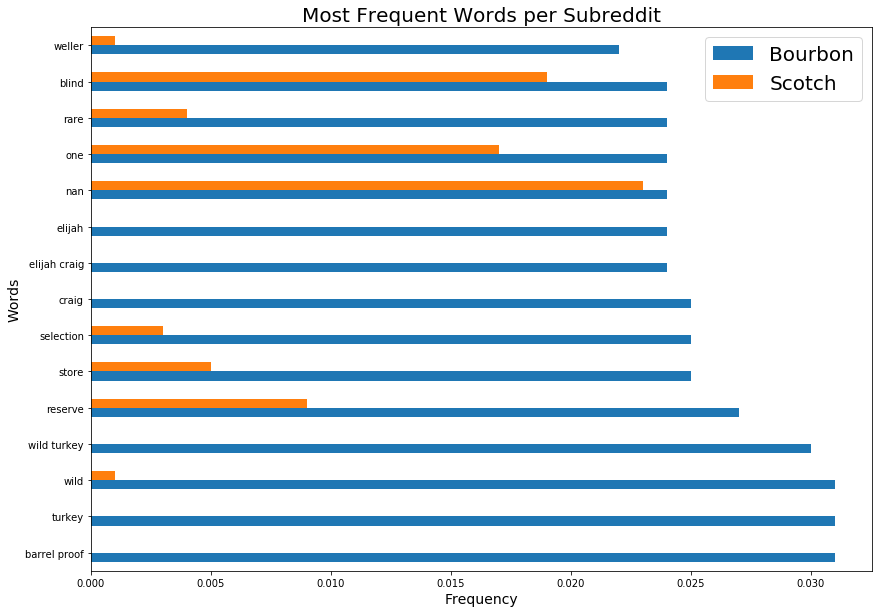

In [63]:
# Plot combined
top_words.plot(y=[0,1], kind="barh", figsize=(14,10))
plt.title("Most Frequent Words per Subreddit", fontsize=20)
plt.ylabel("Words", fontsize=14)
plt.xlabel("Frequency", fontsize=14)
plt.legend(labels = ["Bourbon", "Scotch"], fontsize=20);

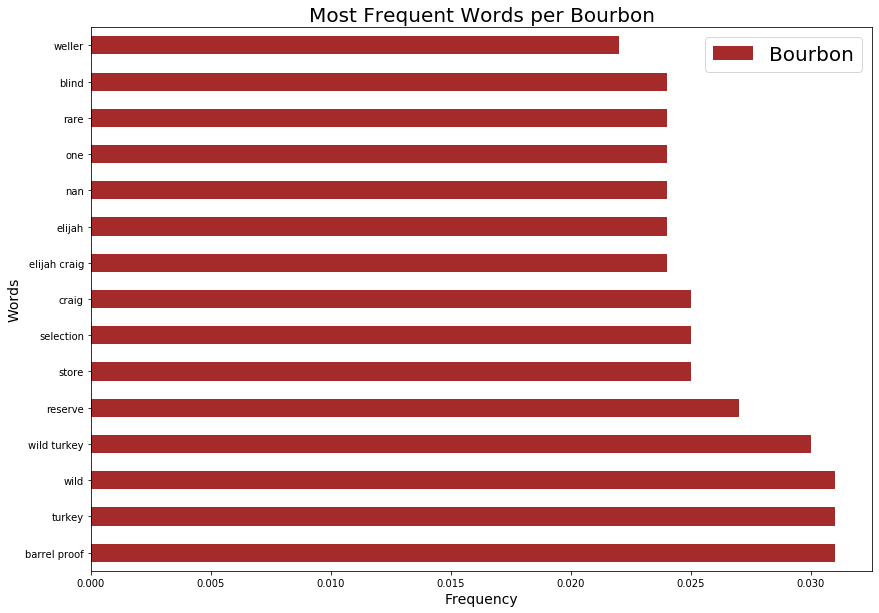

In [64]:
# Plot Bourbon Words
top_words.plot(y=[0], kind="barh", figsize=(14,10), color='Brown')
plt.ylabel("Words", fontsize=14)
plt.xlabel("Frequency", fontsize=14)
plt.title("Most Frequent Words per Bourbon", fontsize=20)
plt.legend(labels = ["Bourbon", "Scotch"], fontsize=20);

In [65]:
# Only Scotch 
top_words_2 = terms_sub_df.groupby('target_subreddit').mean().T.sort_values(1, ascending=False).head(15)

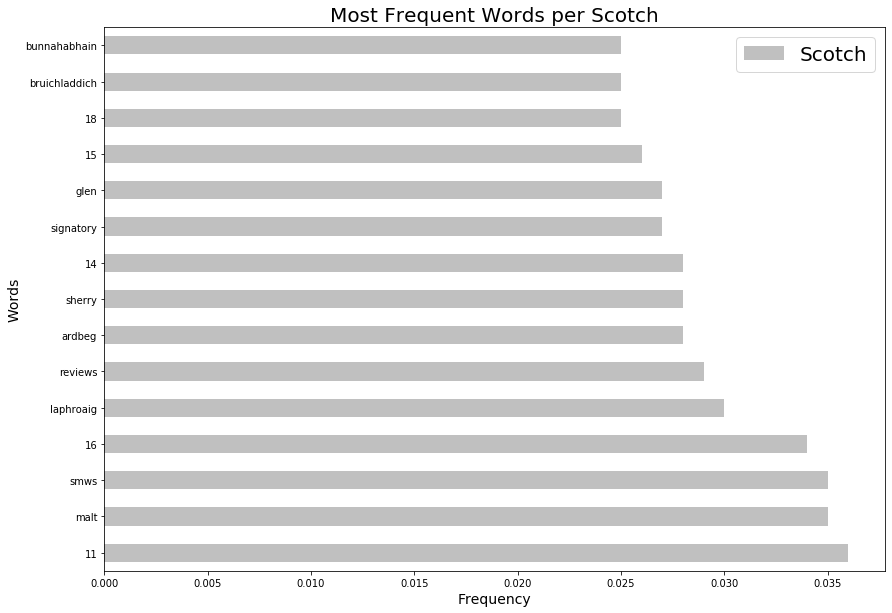

In [66]:
# Plot Scotch Words
top_words_2.plot(y=[1], kind="barh", figsize=(14,10), color='silver')
plt.ylabel("Words", fontsize=14)
plt.xlabel("Frequency", fontsize=14)
plt.title("Most Frequent Words per Scotch", fontsize=20)
plt.legend(labels = ["Scotch"], fontsize=20);